In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd

In [2]:
import sys
sys.path.append('..')

In [3]:
from nbhd.data import Base

Initializing database connection...
Database connected!


In [4]:
db = Base()

In [5]:
from nbhd.geography import Neighbourhood

In [6]:
n = Neighbourhood(load=False)

In [7]:
def get_communities(self, 
                    footprint_threshold=250, 
                    res_length_threshold=30, 
                    short_threshold=50, 
                    min_community_size=0, 
                    node_distance=50):
    
    # nearest roads ~ 'slimroads' is without motorways and secondary roads
    nr_roads = n.db.nearest_neighbours('openroads', n.geom.buffer(10))
    # nearest buildings
    nr_buildings = n.db.nearest_neighbours('openmaplocal', n.geom.buffer(1))
    # merge on UPRN
    df = nr_buildings.merge(nr_roads, on=['UPRN', 'uprn_geometry'], 
                            how='inner', suffixes=('_building', '_street'))

    # 1 eliminate non-building properties : distance to building must == 0
    df1 = df.loc[df.dist_building==0]

    # 2 eliminate non-residential buildings : area / uprn count must < 250
    building_counts = dict(df1.id_building.value_counts())
    df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))
    df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
    df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts
    df1['residential_building'] = df1['footprint_area_per_uprn'] < footprint_threshold
    df2 = df1.loc[df1.residential_building]

    # 3 establish whether roads are residential : length / uprn count must < 5??
    street_counts = dict(df2.id_street.value_counts())
    df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))
    df2['street_length_per_uprn'] = df2.length / df2.street_counts
    df2['residential_street'] = df2.street_length_per_uprn < res_length_threshold
    residential = dict(zip(df2.id_street, df2.residential_street))
    df['residential'] = df.id_street.apply(lambda x: residential.get(x, False))
    df['short_street'] = df.length < short_threshold
    df['res_or_short'] = df.residential | df.short_street
    df3 = df.loc[df.res_or_short]

    # 4 treat nearby nodes as equivalent
    translator = db.get_nearest_nodes_translator(self, node_distance)
    edges = df3.loc[~df3.duplicated()]
    edges['translated_start'] = edges.startNode.apply(lambda x: translator.get(x, x))
    edges['translated_end'] = edges.endNode.apply(lambda x: translator.get(x, x))
   
    # 5 find connected networks of residential streets
    g = nx.from_pandas_edgelist(edges, 'translated_start', 'translated_end', True)
    subgraphs =[g.subgraph(c) for c in nx.connected_components(g)]
    sgs = [sg for sg in subgraphs if len(sg) > 1]

    # 6 add community labels
    communities = dict()
    for i in range(len(sgs)):
        communities[str(i).zfill(2)] = list(nx.get_edge_attributes(sgs[i], 'id_street').values())
    communities_key = {value:key for key, value_list 
                       in communities.items() for value in value_list}

    df['community'] = df.id_street.apply(lambda x: communities_key.get(x, None))
    self.df = df

In [8]:
get_communities(n)

<ipython-input-7-91d2d0971909>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))
<ipython-input-7-91d2d0971909>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
<ipython-input-7-91d2d0971909>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [9]:
import matplotlib.pyplot as plt

In [10]:
n.df.columns

Index(['UPRN', 'uprn_geometry', 'id_building', 'featureCode',
       'geometry_building', 'dist_building', 'id_street', 'endNode',
       'startNode', 'roadNumberTOID', 'roadNameTOID', 'fictitious',
       'roadClassification', 'roadFunction', 'formOfWay', 'length',
       'length_uom', 'loop', 'primaryRoute', 'trunkRoad',
       'roadClassificationNumber', 'name1', 'name1_lang', 'name2',
       'name2_lang', 'roadStructure', 'geometry_street', 'dist_street',
       'residential', 'short_street', 'res_or_short', 'community'],
      dtype='object')

In [11]:
bdg_df = n.df[~n.df[['id_building']].duplicated()][['community', 'geometry_building']]

In [12]:
street_df = n.df[~n.df[['id_street']].duplicated()][['community', 'geometry_street']]

<AxesSubplot:>

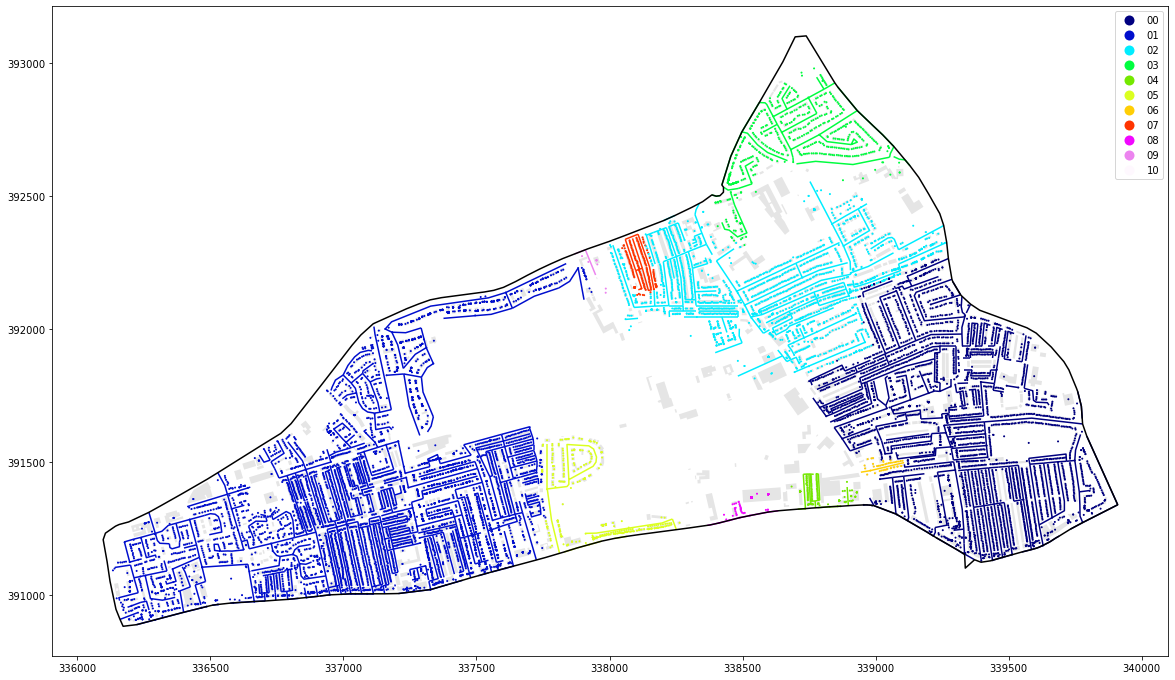

In [13]:
_fig, ax = plt.subplots(figsize=(20,20))
cmap = 'gist_ncar'
# cmap = 'tab20c'
# cmap = 'Set2'
# gpd.GeoDataFrame(n.df[['community']], 
#                  geometry=gpd.GeoSeries(n.df.geometry_street)).plot(
#     'community', ax=ax, linewidth=1, legend=True, cmap='gist_ncar')
gpd.GeoDataFrame(street_df[['community']], 
                 geometry=gpd.GeoSeries(street_df.geometry_street)).plot(
    'community', cmap=cmap, ax=ax, markersize=1, alpha=1)

gpd.GeoDataFrame(bdg_df[['community']], 
                 geometry=gpd.GeoSeries(bdg_df.geometry_building)).plot(
    color='k', ax=ax, markersize=1, alpha=0.1)
gpd.GeoDataFrame(n.df[['community']], 
                 geometry=gpd.GeoSeries.from_wkb(n.df.uprn_geometry)).plot(
    'community', ax=ax, markersize=1, cmap=cmap, alpha=1, legend=True)

n.boundary.plot(ax=ax, linewidth=1.5, color='k')
# plt.savefig()